This Jupyter NB has all of the data preprocessing and modeling for the Team of the Season Predictor. In the Notebook, I will go through data preprocessing, various ML arcitectures that might work for this Classification problem, stastical comparisons between the models, and a final conclusion on what model I will use and why I chose it. Some more insight into the data can be found in WebScrape Juptyer NB found in the Practice folder.

# Data Preprocessing

The first part of this code is from `Webscrape.ipynb`in the Practice folder. 

In [1]:
"""IMPORTS"""
# Data Preprocessing
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

# Web Scraping
import requests
from bs4 import BeautifulSoup
from io import StringIO
import re

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier


# Stastical Comparisons and Data Visualization
from sklearn.metrics import roc_auc_score , classification_report, confusion_matrix , accuracy_score
from sklearn import metrics as mt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
"""HELPING FUNCTIONS"""
labels = ['Not TOTS', 'TOTS']
# Function is from Class Notebook 12a. More Advanced CNN Techniques as TFData.ipynb
# def summarize_net(net, X_test, y_test, title_text=''):
#     plt.figure(figsize=(15, 5))
#     yhat = np.argmax(net.predict(X_test), axis=1)
#     y_true = np.argmax(y_test , axis=1)  # Convert one-hot encoded labels to 1d array
#     acc = mt.accuracy_score(y_true, yhat)
#     cm = mt.confusion_matrix(y_true, yhat)
#     cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
#     sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
#     plt.title(title_text + ' Accuracy: {:.4f}'.format(acc))

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15, 5))
    yhat = net.predict(X_test)
    if yhat.ndim > 1:  # Check if the output is a 2D array
        yhat = np.argmax(yhat, axis=1)
    y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test  # Handle both one-hot and 1D arrays
    acc = mt.accuracy_score(y_true, yhat)
    cm = mt.confusion_matrix(y_true, yhat)
    cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.title(title_text + ' Accuracy: {:.4f}'.format(acc))
    plt.show()

In [3]:
""" WEBSCRAPING PLAYER STATS """

# Player Stats from FBREF
url_2023_2024 = 'https://fbref.com/en/comps/9/stats/Premier-League-Stats'
url_2022_2023 = 'https://fbref.com/en/comps/9/2022-2023/stats/2022-2023-Premier-League-Stats'
url_2021_2022 = 'https://fbref.com/en/comps/9/2021-2022/stats/2021-2022-Premier-League-Stats'
url_2020_2021 = 'https://fbref.com/en/comps/9/2020-2021/stats/2020-2021-Premier-League-Stats'
url_2019_2020 = 'https://fbref.com/en/comps/9/2019-2020/stats/2019-2020-Premier-League-Stats'
url_2018_2019 = 'https://fbref.com/en/comps/9/2018-2019/stats/2018-2019-Premier-League-Stats'
url_2017_2018 = 'https://fbref.com/en/comps/9/2017-2018/stats/2017-2018-Premier-League-Stats'

urls = [ url_2023_2024 , url_2022_2023 , url_2021_2022 , url_2020_2021 , url_2019_2020, url_2018_2019, url_2017_2018]
player_stat_dfs = []


for link in urls:
    # print(link)
    temp = pd.read_html(
        requests.get(link).text.replace('<!--','').replace('-->','')
        ,attrs={'id':'stats_standard'}
    )[0]
    
    # temp = pd.read_html(
    #     requests.get(link).text ,  attrs={'id':'stats_standard'}
    # )[0]
    
    temp_data = pd.DataFrame(temp)
    
    player_stat_dfs.append(temp_data)
    


"""PULLING TEAM OF THE SEASON INFO"""
"""TARGET SEASONS: 2017-2018 - 2023-2024"""


# Get URLS for TOTS info
url_tots_wiki_2020s = 'https://en.wikipedia.org/wiki/PFA_Team_of_the_Year_(2020s)'
url_tots_wiki_2010s = 'https://en.wikipedia.org/wiki/PFA_Team_of_the_Year_(2010s)'

tots_urls = [url_tots_wiki_2020s , url_tots_wiki_2010s]
tots_dfs = []

for url in tots_urls:
    
    # Send an HTTP GET request to the URL
    temp_response = requests.get(url)
    
    if temp_response.status_code == 200:
        # Parse the HTML content
        soup = BeautifulSoup(temp_response.content, 'html.parser')
        
        # Find Where all the PL Headers are 
        h4_headers = soup.find_all('h4')
        
        # Get PL Tags
        premier_league_tags = [tag for tag in h4_headers if 'Premier League' in tag.text]
        
        
        
        for header in premier_league_tags:
            # Find the next sibling table tag
            table = header.find_next_sibling('table')
            
            # If a table is found, print it
            if table:
                df = pd.read_html(StringIO(str(table)))[0]
                tots_dfs.append(df) 
    
    else:
        print("Failed to retrieve the page. Status code:", temp_response.status_code)

/var/folders/_x/czhgmpkn0lx4yd57n3w9bwv00000gn/T/ipykernel_8847/3026935382.py:18: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  temp = pd.read_html(
/var/folders/_x/czhgmpkn0lx4yd57n3w9bwv00000gn/T/ipykernel_8847/3026935382.py:18: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  temp = pd.read_html(
/var/folders/_x/czhgmpkn0lx4yd57n3w9bwv00000gn/T/ipykernel_8847/3026935382.py:18: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  temp = pd.read_html(
/var/folders/_x/czhgmpkn0lx4yd57n3w9bwv00000gn/T/ipykernel_8847/3026935382.py:18: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future

In [4]:
"""PUT TABLES INTO DICTIONARY BY YEAR"""

yr_playerStat_dict = {
    '2023-2024' : player_stat_dfs[0],
    '2022-2023' : player_stat_dfs[1],
    '2021-2022' : player_stat_dfs[2],
    '2020-2021' : player_stat_dfs[3],
    '2019-2020' : player_stat_dfs[4],
    '2018-2019' : player_stat_dfs[5],
    '2017-2018' : player_stat_dfs[6]
}

"""MAPPING TABLES TO APROPRIATE YEAR IN DICTIONARY (year -> TOTS Table)"""

yr_totsNoms_dict = {
    '2019-2020' : tots_dfs[0] ,
    '2020-2021' : tots_dfs[1] ,
    '2021-2022' : tots_dfs[2] ,
    '2022-2023' : tots_dfs[3] , 
    '2017-2018' : tots_dfs[-2] , 
    '2018-2019' : tots_dfs[-1] , 
}

In [5]:
list_seasons = ['2017-2018' , '2018-2019' , '2019-2020' , '2020-2021', '2021-2022' , '2022-2023'] # Exclude current Season

# All DataFrames Stored
merged_dataframes = []

for szn in list_seasons:
    tmp_tots_stats = yr_totsNoms_dict[szn]
    tmp_plyr_stats = yr_playerStat_dict[szn]
    
    # Strip Player name to get rid of special chars
    tmp_tots_stats['Player'] = tmp_tots_stats['Player'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).strip())
    
    # Updating Names for TOTS Nominees Table to match Player Stats DF
    tmp_tots_stats = tmp_tots_stats.rename(columns={'App.': 'Tots_Apps' , 'Pos.': 'Pos' , 'Club': 'Squad'})
    
    # Drop Upper Level Layers
    tmp_plyr_stats.columns = tmp_plyr_stats.columns.droplevel([0])
    
    # Merge the DataFrames
    # Join tables, keep all of info from player stats , join on Player name and squad
    tmp_df_merged = pd.merge(tmp_plyr_stats, tmp_tots_stats, on=['Player', 'Squad'], how='left')
    
    #Fix Pos_x 
    tmp_df_merged['Pos'] = tmp_df_merged['Pos_x'].str.split(',').str[0]
    
    # If Tots_Apps = NaN
    # Make that = 0
    tmp_df_merged['Tots_Apps'] = tmp_df_merged['Tots_Apps'].fillna(0)
    
    # Nation 
    # Use the ALL CAPS Countries
    tmp_df_merged['Nation'] = tmp_df_merged['Nation'].str.split().str[-1]
    
    # Drop Matches, Rk , Extra Pos's
    tmp_df_merged = tmp_df_merged.drop(columns=['Rk', 'Matches' , 'Pos_x' , 'Pos_y' ])
    
    merged_dataframes.append(tmp_df_merged)
    
    
for mdf in merged_dataframes: mdf.drop(mdf[mdf['Player'] == 'Player'].index, inplace=True)

In [6]:
print(len(merged_dataframes))
merged_dataframes[0]

6


,Player,Nation,Squad,Age,Born,MP,Starts,Min,90s,Gls,...,G+A,G-PK,G+A-PK,xG,xAG,xG+xAG,npxG,npxG+xAG,Tots_Apps,Pos
0,Patrick van Aanholt,NED,Crystal Palace,26,1990,28,25,2184,24.3,5,...,0.25,0.21,0.25,0.13,0.09,0.21,0.13,0.21,0.0,DF
1,Rolando Aarons,ENG,Newcastle Utd,21,1995,4,1,139,1.5,0,...,0.00,0.00,0.00,0.04,0.00,0.04,0.04,0.04,0.0,MF
2,Tammy Abraham,ENG,Swansea City,19,1997,31,15,1726,19.2,5,...,0.31,0.26,0.31,0.35,0.08,0.44,0.35,0.44,0.0,FW
3,Charlie Adam,SCO,Stoke City,31,1985,11,5,411,4.6,0,...,0.00,0.00,0.00,0.36,0.27,0.63,0.19,0.46,0.0,MF
4,Adrián,ESP,West Ham,30,1987,19,19,1710,19.0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,GK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,Wilfried Zaha,CIV,Crystal Palace,24,1992,29,28,2549,28.3,9,...,0.42,0.32,0.42,0.33,0.17,0.49,0.33,0.49,0.0,FW
546,Davide Zappacosta,ITA,Chelsea,25,1992,22,12,1098,12.2,1,...,0.16,0.08,0.16,0.11,0.11,0.22,0.11,0.22,0.0,DF
547,Marvin Zeegelaar,NED,Watford,26,1990,12,12,994,11.0,0,...,0.09,0.00,0.09,0.00,0.09,0.09,0.00,0.09,0.0,DF
548,Oleksandr Zinchenko,UKR,Manchester City,20,1996,8,6,532,5.9,0,...,0.00,0.00,0.00,0.02,0.07,0.09,0.02,0.09,0.0,DF


#### Cleaning the Data

In [7]:
# Add in the target column
for mdf in merged_dataframes:
    mdf['TOTS'] = mdf['Tots_Apps'].apply(lambda x: 1 if x > 0 else 0)

In [8]:
merged_dataframes[4].head(20)

,Player,Nation,Squad,Age,Born,MP,Starts,Min,90s,Gls,...,G-PK,G+A-PK,xG,xAG,xG+xAG,npxG,npxG+xAG,Tots_Apps,Pos,TOTS
0,Max Aarons,ENG,Norwich City,21,2000,34,32,2881,32.0,0,...,0.00,0.06,0.03,0.05,0.08,0.03,0.08,0.0,DF,0
1,Che Adams,SCO,Southampton,25,1996,30,23,2039,22.7,7,...,0.31,0.44,0.31,0.13,0.45,0.31,0.45,0.0,FW,0
2,Rayan Aït-Nouri,ALG,Wolves,20,2001,23,20,1828,20.3,1,...,0.05,0.15,0.03,0.08,0.11,0.03,0.11,0.0,DF,0
3,Kristoffer Ajer,NOR,Brentford,23,1998,24,23,1995,22.2,1,...,0.05,0.18,0.04,0.08,0.11,0.04,0.11,0.0,DF,0
4,Nathan Aké,NED,Manchester City,26,1995,14,10,923,10.3,2,...,0.20,0.20,0.07,0.06,0.12,0.07,0.12,0.0,DF,0
5,Marc Albrighton,ENG,Leicester City,31,1989,17,11,1132,12.6,1,...,0.08,0.24,0.04,0.16,0.20,0.04,0.20,0.0,FW,0
6,Thiago Alcántara,ESP,Liverpool,30,1991,25,17,1534,17.0,1,...,0.06,0.29,0.11,0.14,0.25,0.11,0.25,0.0,MF,0
7,Trent Alexander-Arnold,ENG,Liverpool,22,1998,32,32,2853,31.7,2,...,0.06,0.44,0.07,0.38,0.46,0.07,0.46,0.0,DF,0
8,Alisson,BRA,Liverpool,28,1992,36,36,3240,36.0,0,...,0.00,0.03,0.00,0.01,0.01,0.00,0.01,1.0,GK,1
9,Allan,BRA,Everton,30,1991,28,25,2183,24.3,0,...,0.00,0.08,0.01,0.03,0.04,0.01,0.04,0.0,MF,0


#### Decision Making

In [9]:
total_plyrs = 0
tots_plyrs = 11 * len(merged_dataframes)
for merged_df in merged_dataframes:
    total_plyrs += len(merged_df)

print(f"Players in TOTS over 6 years: { tots_plyrs }")
print(f"Players with stats over 6 years: { total_plyrs }")
print(f"Percentage of players that are in TOTS: % {tots_plyrs /total_plyrs * 100 }")

Players in TOTS over 6 years: 66
Players with stats over 6 years: 3206
Percentage of players that are in TOTS: % 2.0586400499064252


From the code above, we can see that we have major class imbalance when putting the DataFrames together. We will see how the model works out and if it performs well when the data is put together across different seasons. 

The reasoning behind putting the data together is that I am hoping to find a consistent standard on certain stats that lead to a player being nominated for TOTS. If I can establish this relationship, then I can use the stats for a players current season, find out what they average to, find an expected total, and use that to predict if they will make TOTS or not.

For this predict method we will have to look into Fbeta scores and see how our model performs using a confusion matrix. I also need to establish if False Positives or False Positives are more important.

In [10]:
"""JOINING THE TABLES"""
df = pd.concat(merged_dataframes)
df

,Player,Nation,Squad,Age,Born,MP,Starts,Min,90s,Gls,...,G-PK,G+A-PK,xG,xAG,xG+xAG,npxG,npxG+xAG,Tots_Apps,Pos,TOTS
0,Patrick van Aanholt,NED,Crystal Palace,26,1990,28,25,2184,24.3,5,...,0.21,0.25,0.13,0.09,0.21,0.13,0.21,0.0,DF,0
1,Rolando Aarons,ENG,Newcastle Utd,21,1995,4,1,139,1.5,0,...,0.00,0.00,0.04,0.00,0.04,0.04,0.04,0.0,MF,0
2,Tammy Abraham,ENG,Swansea City,19,1997,31,15,1726,19.2,5,...,0.26,0.31,0.35,0.08,0.44,0.35,0.44,0.0,FW,0
3,Charlie Adam,SCO,Stoke City,31,1985,11,5,411,4.6,0,...,0.00,0.00,0.36,0.27,0.63,0.19,0.46,0.0,MF,0
4,Adrián,ESP,West Ham,30,1987,19,19,1710,19.0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,GK,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,Jordan Zemura,ZIM,Bournemouth,22,1999,19,17,1454,16.2,0,...,0.00,0.06,0.02,0.11,0.14,0.02,0.14,0.0,DF,0
587,Oleksandr Zinchenko,UKR,Arsenal,25,1996,27,26,2118,23.5,1,...,0.04,0.13,0.06,0.06,0.12,0.06,0.12,0.0,DF,0
588,Hakim Ziyech,MAR,Chelsea,29,1993,18,6,661,7.3,0,...,0.00,0.41,0.08,0.30,0.38,0.08,0.38,0.0,FW,0
589,Kurt Zouma,FRA,West Ham,27,1994,25,24,1989,22.1,2,...,0.09,0.09,0.10,0.00,0.10,0.10,0.10,0.0,DF,0


In this section, we are going to make the 'Squad' column into a ordinal categorical variable by ordering the squads by average league position over the time we are getting the data. We are doing this because when looking at TOTS data, it is evident that teams that place higher in the standings tend to have more players in the TOTS. This is a big assumption I am making, so if it does not seem to have an affect on what we get from the model, I will find another way to handle this.

To accomplish this, we need to do more webscraping from fbref to find the tables and get the average position for each team that played in the Premier League in the timeframe from the 2017-18 season to the 2022-2023 season. 

In [11]:
list_seasons = ['2017-2018' , '2018-2019' , '2019-2020' , '2020-2021', '2021-2022' , '2022-2023'] # Exclude current Season

# This is going to be used to store the average position of a team in their time in the premier league. 
# The key will be a team's name, and the value will be a tuple of (sum of league position, number of appearances in premier league)
teams_in_prem = {}

for szn in list_seasons:
    url_temp = f'https://fbref.com/en/comps/9/{szn}/{szn}-Premier-League-Stats'
    # print(url_temp)
    # Send an HTTP GET request to the URL
    temp_response = requests.get(url_temp)
    
    if temp_response.status_code == 200:
        # Parse the HTML content
        soup = BeautifulSoup(temp_response.content, 'html.parser')

        # Find Where all the Regular Season Headers are 
        table = soup.find_all('table')[0]
        # Get PL Tags
        # print(table)
        
        # soup2 = BeautifulSoup(table, 'html.parser')
        
        # Step 3: Find all the <tr> tags
        rows = table.find_all('tr')

        # Step 4: Loop through each <tr> tag and extract data
        # Skip Header Row
        # print(f"Season {szn}")
        for row in rows[1:]:
            # Find all <td> or <th> tags within this row
            cells = row.find_all(['td', 'th'])
            
            # Extract the text content from each cell
            cell_data = [cell.get_text(strip=True) for cell in cells]
            
            # Print or process the cell data as needed
            # Pull out name and position
            temp_team_name = cell_data[1]
            temp_position = int(cell_data[0])
            
            # print(f"Team: {temp_team_name} , Position: {temp_position}")
    
            # Store Team In Dictionary:
            # Dicitionary: 
            # Key --> Team Name
            # Value --> Tuple(Sum of Positions , Times Appear in Prem)
            
            # If the tuple is in the 
            if not temp_team_name in teams_in_prem: teams_in_prem[temp_team_name] = (0 , 0)
            
            # Update the tuple with new values
            current_sum, current_appearances = teams_in_prem[temp_team_name]
            teams_in_prem[temp_team_name] = (current_sum + temp_position, current_appearances + 1)


team_avg_pos_dict = {} 
    
# Check Averages        
# for ke , el in teams_in_prem.items(): 
#     print(f"Team: {ke} | Average League Pos: {el[0] / el[1]}")
team_avg_pos_dict = {ke: el[0] / el[1] for ke, el in teams_in_prem.items()}


# Ordering the dict by avg position
sorted_team_avg_pos_dict = sorted(team_avg_pos_dict.items(), key=lambda x:x[1])
# sorted_team_avg_pos_dict = dict(sorted(team_avg_pos_dict.items(), key=lambda item: item))


# Print the sorted list
for team, avg_position in sorted_team_avg_pos_dict:
    print(f"Team: {team} | Average League Pos: {avg_position:.2f}")


Team: Manchester City | Average League Pos: 1.17
Team: Liverpool | Average League Pos: 2.83
Team: Manchester Utd | Average League Pos: 3.67
Team: Chelsea | Average League Pos: 5.17
Team: Tottenham | Average League Pos: 5.33
Team: Arsenal | Average League Pos: 5.67
Team: Leicester City | Average League Pos: 9.00
Team: Wolves | Average League Pos: 10.00
Team: Newcastle Utd | Average League Pos: 10.50
Team: West Ham | Average League Pos: 11.00
Team: Brentford | Average League Pos: 11.00
Team: Everton | Average League Pos: 11.83
Team: Aston Villa | Average League Pos: 12.25
Team: Crystal Palace | Average League Pos: 12.33
Team: Brighton | Average League Pos: 13.00
Team: Burnley | Average League Pos: 13.40
Team: Sheffield Utd | Average League Pos: 14.50
Team: Bournemouth | Average League Pos: 14.75
Team: Leeds United | Average League Pos: 15.00
Team: Southampton | Average League Pos: 15.67
Team: Fulham | Average League Pos: 15.67
Team: Watford | Average League Pos: 15.75
Team: Nott'ham Fore

In [12]:
# Now I will apply this to the Squad attribute 
 
# Create Dict that will map to squad:
squad_dict = {}

# Make a dictionary based on the name of the team and the position theyre in
for i in range(len(sorted_team_avg_pos_dict)): squad_dict[sorted_team_avg_pos_dict[i][0]] = i + 1

# Print out Ordering
# for s in squad_dict: print(s)


df['Squad_ordinal'] = df.Squad.map(squad_dict)
df

,Player,Nation,Squad,Age,Born,MP,Starts,Min,90s,Gls,...,G+A-PK,xG,xAG,xG+xAG,npxG,npxG+xAG,Tots_Apps,Pos,TOTS,Squad_ordinal
0,Patrick van Aanholt,NED,Crystal Palace,26,1990,28,25,2184,24.3,5,...,0.25,0.13,0.09,0.21,0.13,0.21,0.0,DF,0,14
1,Rolando Aarons,ENG,Newcastle Utd,21,1995,4,1,139,1.5,0,...,0.00,0.04,0.00,0.04,0.04,0.04,0.0,MF,0,9
2,Tammy Abraham,ENG,Swansea City,19,1997,31,15,1726,19.2,5,...,0.31,0.35,0.08,0.44,0.35,0.44,0.0,FW,0,25
3,Charlie Adam,SCO,Stoke City,31,1985,11,5,411,4.6,0,...,0.00,0.36,0.27,0.63,0.19,0.46,0.0,MF,0,27
4,Adrián,ESP,West Ham,30,1987,19,19,1710,19.0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,GK,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,Jordan Zemura,ZIM,Bournemouth,22,1999,19,17,1454,16.2,0,...,0.06,0.02,0.11,0.14,0.02,0.14,0.0,DF,0,18
587,Oleksandr Zinchenko,UKR,Arsenal,25,1996,27,26,2118,23.5,1,...,0.13,0.06,0.06,0.12,0.06,0.12,0.0,DF,0,6
588,Hakim Ziyech,MAR,Chelsea,29,1993,18,6,661,7.3,0,...,0.41,0.08,0.30,0.38,0.08,0.38,0.0,FW,0,4
589,Kurt Zouma,FRA,West Ham,27,1994,25,24,1989,22.1,2,...,0.09,0.10,0.00,0.10,0.10,0.10,0.0,DF,0,10


In [13]:
"""ONE HOT ENCODING POSITION"""
le = LabelEncoder()
# Fit the encoder (learn mappings)
le.fit(df['Pos'])

# Transform categorical data and create a new column
df['Pos_encoded'] = le.transform(df['Pos'])
df

,Player,Nation,Squad,Age,Born,MP,Starts,Min,90s,Gls,...,xG,xAG,xG+xAG,npxG,npxG+xAG,Tots_Apps,Pos,TOTS,Squad_ordinal,Pos_encoded
0,Patrick van Aanholt,NED,Crystal Palace,26,1990,28,25,2184,24.3,5,...,0.13,0.09,0.21,0.13,0.21,0.0,DF,0,14,0
1,Rolando Aarons,ENG,Newcastle Utd,21,1995,4,1,139,1.5,0,...,0.04,0.00,0.04,0.04,0.04,0.0,MF,0,9,3
2,Tammy Abraham,ENG,Swansea City,19,1997,31,15,1726,19.2,5,...,0.35,0.08,0.44,0.35,0.44,0.0,FW,0,25,1
3,Charlie Adam,SCO,Stoke City,31,1985,11,5,411,4.6,0,...,0.36,0.27,0.63,0.19,0.46,0.0,MF,0,27,3
4,Adrián,ESP,West Ham,30,1987,19,19,1710,19.0,0,...,0.00,0.00,0.00,0.00,0.00,0.0,GK,0,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,Jordan Zemura,ZIM,Bournemouth,22,1999,19,17,1454,16.2,0,...,0.02,0.11,0.14,0.02,0.14,0.0,DF,0,18,0
587,Oleksandr Zinchenko,UKR,Arsenal,25,1996,27,26,2118,23.5,1,...,0.06,0.06,0.12,0.06,0.12,0.0,DF,0,6,0
588,Hakim Ziyech,MAR,Chelsea,29,1993,18,6,661,7.3,0,...,0.08,0.30,0.38,0.08,0.38,0.0,FW,0,4,1
589,Kurt Zouma,FRA,West Ham,27,1994,25,24,1989,22.1,2,...,0.10,0.00,0.10,0.10,0.10,0.0,DF,0,10,0


In [14]:
"""DROP UNNECESSARY COLUMNS"""
df = df.drop(columns=['Squad' , 'Player', 'Nation', 'Born', 'Pos','Tots_Apps'])

In [15]:
pd.options.display.max_columns = 33
print(df.head(1))

  Age  MP Starts   Min   90s Gls Ast G+A G-PK PK PKatt CrdY CrdR   xG npxG  \
0  26  28     25  2184  24.3   5   1   6    5  0     0    7    0  3.1  3.1   

   xAG npxG+xAG PrgC PrgP PrgR   Gls   Ast   G+A  G-PK G+A-PK    xG   xAG  \
0  2.1      5.2   46   92   86  0.21  0.04  0.25  0.21   0.25  0.13  0.09   

  xG+xAG  npxG npxG+xAG  TOTS  Squad_ordinal  Pos_encoded  
0   0.21  0.13     0.21     0             14            0  


## Modeling 

We now have our dataset that we will use for the models, and now we will start the actual modeling. We will be trying out are going to be a Logistic Regression Model, a Decision Trees Model, and a Multilayer Perceptron. We will do our final prep for the modeling, including dealing with the class imbalance.

#### Prepping Data For Modeling

In [16]:
X = df.drop(columns=['TOTS'])
y = df['TOTS']

print(len(X))
print(len(y))

# Stratified splitting for class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

imputer = IterativeImputer(max_iter=10, random_state=42)  # Adjust parameters as needed
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

#Normalize the dataset
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

3206
3206


#### Logistic Regression

/Users/marcoszertuche/anaconda3/envs/PersonalProject/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC-ROC: 0.634260586941975
Accuracy: 0.9875259875259875
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       951
           1       0.43      0.27      0.33        11

    accuracy                           0.99       962
   macro avg       0.71      0.63      0.66       962
weighted avg       0.99      0.99      0.99       962



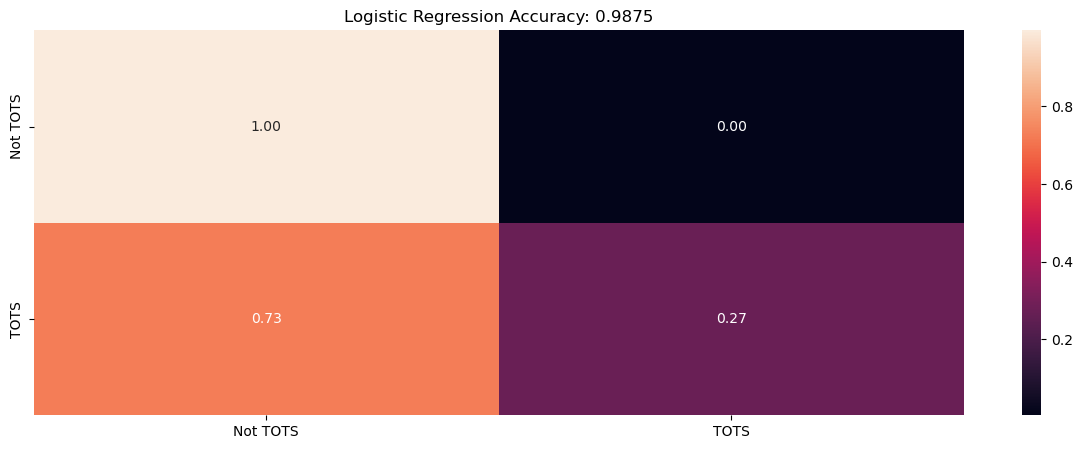

In [23]:
# Logistic Regression Model
lr_model = LogisticRegression()  
lr_model.fit(X_train_imputed, y_train)

y_pred_lr = lr_model.predict(X_test_imputed)

# Evaluate AUC-ROC to see performance
auc_lr = roc_auc_score(y_test, y_pred_lr)  
class_report_dtc = classification_report(y_test, y_pred_lr)

print('AUC-ROC:', auc_lr)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", class_report_dtc)

summarize_net(lr_model, X_test_imputed, y_test , title_text = 'Logistic Regression')

In [18]:
# Get and show coefficients to find feature influence
importances = lr_model.coef_[0]
features = X.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# print(importances_df)

#### Decision Tree Classifier

In [19]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train_imputed, y_train)

y_pred_dtc = dtc.predict(X_test_imputed)

auc_dtc = roc_auc_score(y_test, y_pred_lr)  
class_report_dtc = classification_report(y_test, y_pred_dtc)


print('AUC-ROC:', auc_dtc)
print("Accuracy:", accuracy_score(y_test, y_pred_dtc))
print("Classification Report:\n", class_report_dtc)

summarize_net(dtc, X_test_imputed, y_test , title_text = 'Decision Tree Classifier')

AUC-ROC: 0.634260586941975
Accuracy: 0.9792099792099792
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       951
           1       0.24      0.36      0.29        11

    accuracy                           0.98       962
   macro avg       0.61      0.67      0.64       962
weighted avg       0.98      0.98      0.98       962



#### Neural Network Classifier

In [20]:
# Create an MLPClassifier model
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),
                    max_iter=1000, random_state=42)

# Train the model on the training data
mlp.fit(X_train_imputed, y_train)

y_pred_mlp = mlp.predict(X_test_imputed)

auc_mlp = roc_auc_score(y_test, y_pred_mlp)  
class_report_mlp = classification_report(y_test, y_pred_mlp)

print('AUC-ROC:', auc_mlp)
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", class_report_mlp)

summarize_net(mlp, X_test_imputed, y_test , title_text = 'Multi Layer Perceptron')

AUC-ROC: 0.7167574801644203
Accuracy: 0.972972972972973
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       951
           1       0.20      0.45      0.28        11

    accuracy                           0.97       962
   macro avg       0.60      0.72      0.63       962
weighted avg       0.98      0.97      0.98       962

